Import needed libraries

In [23]:
import json
import os
import re
import matplotlib.pyplot as plt

Load and Explore the dataset

In [5]:
def load_json_file(file_path):
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f.readlines()]

In [ ]:
# Get the path relative to this file (src/data_loader.py)
#BASE_DIR = os.path.dirname(os.path.dirname(__file__))  ###--> does not work for jupyter notebooks
BASE_DIR = os.path.dirname(os.getcwd()) #Going up a level in the folder
DATA_DIR = os.path.join(BASE_DIR, "data")
train_path = os.path.join(DATA_DIR, "train.json")
val_path = os.path.join(DATA_DIR, "dev.json")

In [12]:
train_data = load_json_file(train_path)
val_data = load_json_file(val_path)

In [ ]:
train_data

[{'5a665142846392001a1e1ac0': {'original': 'What did the government want Thoreau to do?',
   'disfluent': 'Who did no What did the government want Thoreau to do?'},
  '572821274b864d1900164514': {'original': 'What makes the Wells Fargo Center stand out?',
   'disfluent': 'What makes the Bank of America Tower or wait the Wells Fargo Center stand out?'},
  '57300888b2c2fd1400568778': {'original': "What was the Colonia Agrippina's original name?",
   'disfluent': "What was the Colonia Agrippina's original empire, sorry, name?"},
  '5a55234d134fea001a0e1978': {'original': 'Extended networking benefits helped those that could not connect to what platform? ',
   'disfluent': 'Extended authorization limitations, no sorry networking benefits helped those that could not connect to what platform?'},
  '5a25e8d5ef59cd001a623d16': {'original': 'Who is the emphasis on when there is a private finance initiative?',
   'disfluent': 'What is the no make that who is the emphasis on when there is a priva

The data's structure is a list with 1 large dictionary. I'll need to flatten it 

In [16]:
def flatten_file_structure(train_data):
    examples = []
    # Flatten all (disfluent, original) pairs
    for sample_dict in train_data:
        for _id, qa_pair in sample_dict.items():
            examples.append({
                "input_text": qa_pair["disfluent"],
                "target_text": qa_pair["original"]
            })
    return examples

In [17]:
train_data = flatten_file_structure(train_data)
train_data

[{'input_text': 'What do petrologists no what do unstable isotope studies indicate?',
  'target_text': 'What do unstable isotope studies indicate?'},
 {'input_text': 'What is the second level of territorial division in Poland no make that the basic unit of territorial division in Warsaw?',
  'target_text': 'What is the basic unit of territorial division in Warsaw?'},
 {'input_text': 'Juvenile platyctenids no wow Which genus lack tentacles and sheaths?',
  'target_text': 'Which genus lack tentacles and sheaths?'},
 {'input_text': 'When a pathogen is met again scratch that I mean long-lived memory cells are capable of remembering previous encounters with what?',
  'target_text': 'Long-lived memory cells can remember previous encounters with what?'},
 {'input_text': "What led to the Duke of Cumberland's rise to power as military advisor sorry no Newcastle's?",
  'target_text': "What led to Newcastle's rise to power as military advisor?"},
 {'input_text': 'Did Julia Butterfly wait How long

### Perform EDA

##### 1. Look at words distribution

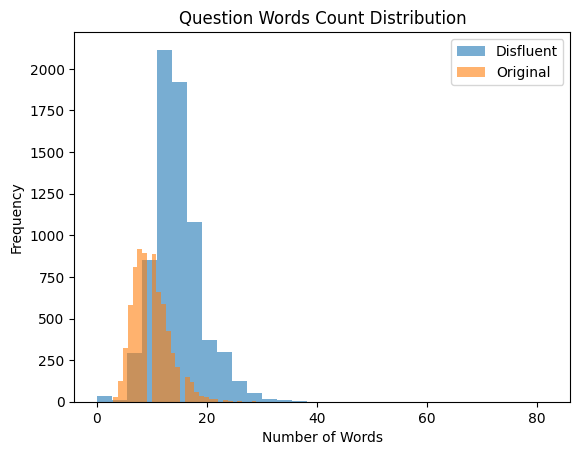

In [30]:
disfluent_lens = [len(e["input_text"].split()) for e in train_data]
original_lens = [len(e["target_text"].split()) for e in train_data]

plt.hist(disfluent_lens, bins=30, alpha=0.6, label="Disfluent")
plt.hist(original_lens, bins=30, alpha=0.6, label="Original")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.title("Question Words Count Distribution")
plt.show()

 This means that the number of words is in general higher in the disfluent questions than the original question

##### 2. Look at the most common disfluency tokens(i.e. top 20 most common extra words)

In [26]:
def normalize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

def get_disfluency_tokens_dict(examples):
    freq = {}
    for e in examples:
        dis = normalize(e["input_text"]).split()
        ori = normalize(e["target_text"]).split()
        dis_set = set(dis)
        ori_set = set(ori)
        extra = dis_set - ori_set
        for word in extra:
            freq[word] = freq.get(word, 0) + 1
    return freq

In [29]:
disfluency_tokens = get_disfluency_tokens_dict(train_data)

# Sort and print top 20 most frequent
top_20 = sorted(disfluency_tokens.items(), key=lambda x: x[1], reverse=True)[:20]
for word, count in top_20:
    print(f"{word}: {count}")

no: 3714
or: 1632
i: 929
sorry: 812
that: 800
rather: 756
mean: 682
make: 630
uh: 599
what: 497
how: 433
er: 432
um: 377
which: 359
the: 356
wait: 356
when: 327
actually: 316
me: 267
was: 265


##### 3. Look at the generalized edits for the disfluent version relative to target version

In [33]:
num_longer = sum(len(e["input_text"].split()) > len(e["target_text"].split()) for e in train_data)
print(f"{num_longer}/{len(train_data)} disfluent questions are longer than original.")

7083/7182 disfluent questions are longer than original.


In [ ]:
disfluent_lengths = [len(e["input_text"].split()) for e in train_data]
avg_disfluent_lengths=sum(disfluent_lengths)/len(disfluent_lengths)
print(f"Avg disfluent length: {avg_disfluent_lengths:.2f} words")
target_length = [len(e["target_text"].split()) for e in train_data]
avg_target_length=sum(target_length)/len(target_length)
print(f"Avg normal length: {avg_target_length:.2f} words")
print(f'The average length that the disfluent words are greater than the regular words is : {(avg_disfluent_lengths/avg_target_length):.2f}')

Avg disfluent length: 14.52 words
Avg normal length: 9.83 words
The average length that the disfluent words are greater than the regular words is : 1.48


##### 4. Look at the number of questions where the rephrase is significantly different

In [57]:
completely_different = []

for e in train_data:
    input_text = e["input_text"].strip().lower()
    target_text = e["target_text"].strip().lower()

    if input_text != target_text and target_text not in input_text:
        completely_different.append(e)

print(f"{len(completely_different)} are major rephrasings.")
print(f"{len(completely_different)/len(train_data)*100:.2f}% of major rephrasings.")

4712 are major rephrasings.
65.61% of major rephrasings.


In [58]:
completely_different

[{'input_text': 'What is the second level of territorial division in Poland no make that the basic unit of territorial division in Warsaw?',
  'target_text': 'What is the basic unit of territorial division in Warsaw?'},
 {'input_text': 'When a pathogen is met again scratch that I mean long-lived memory cells are capable of remembering previous encounters with what?',
  'target_text': 'Long-lived memory cells can remember previous encounters with what?'},
 {'input_text': "What led to the Duke of Cumberland's rise to power as military advisor sorry no Newcastle's?",
  'target_text': "What led to Newcastle's rise to power as military advisor?"},
 {'input_text': 'When was Frankfurt ranked as the 22nd most liveable city in the world, no sorry it was Warsaw?',
  'target_text': 'When was Warsaw ranked as the 22nd most liveable city in the world?'},
 {'input_text': 'What is the name of the number theory, or rather, the supposition that any number larger than 2 can be represented as the sum of 

##### 4.1 Quantifying the Rephrasing distribution, from a heuristic point of view, which is not very accurate

In [74]:
# correction_markers = ["no i mean", "sorry", "i mean", "make that"]
# restart_markers = ["no", "uh", "um", "wait", "who did no", "what did no"]
#Updated list that is made out of the obtained top 20 tokens frequency calculated previously
# Correction markers using top disfluency tokens
correction_markers = [
    "no i mean", "i mean", "sorry", "make that", "actually", "rather", "no sorry", "no actually"
]

# Restart markers using top disfluency tokens
restart_markers = [
    "uh", "um", "no", "wait", "er", "what", "how", "when", "no what", "uh what", "um what"
]

def classify_disfluency(example):
    input_text = example["input_text"].lower()
    
    if any(marker in input_text for marker in correction_markers):
        return "correction"
    elif any(marker in input_text for marker in restart_markers):
        return "restart"
    else:
        return "uncategorized"

# Apply to your dataset
corrections = []
restarts = []
uncategorized = []

for e in train_data:
    category = classify_disfluency(e)
    if category == "correction":
        corrections.append(e)
    elif category == "restart":
        restarts.append(e)
    else:
        uncategorized.append(e)

# Summary statistics
print(f"Corrections: {len(corrections)}")
print(f"Restarts: {len(restarts)}")
print(f"Uncategorized: {len(uncategorized)}")
print(f'The percentage of categorized disfluencies are : {(len(corrections)+len(restarts))/len(train_data)*100:.2f}%.')

Corrections: 3174
Restarts: 3960
Uncategorized: 48
The percentage of categorized disfluencies are : 99.33%.


In [78]:
corrections

[{'input_text': 'What is the second level of territorial division in Poland no make that the basic unit of territorial division in Warsaw?',
  'target_text': 'What is the basic unit of territorial division in Warsaw?'},
 {'input_text': 'When a pathogen is met again scratch that I mean long-lived memory cells are capable of remembering previous encounters with what?',
  'target_text': 'Long-lived memory cells can remember previous encounters with what?'},
 {'input_text': "What led to the Duke of Cumberland's rise to power as military advisor sorry no Newcastle's?",
  'target_text': "What led to Newcastle's rise to power as military advisor?"},
 {'input_text': 'When was Frankfurt ranked as the 22nd most liveable city in the world, no sorry it was Warsaw?',
  'target_text': 'When was Warsaw ranked as the 22nd most liveable city in the world?'},
 {'input_text': 'What is the name of the number theory, or rather, the supposition that any number larger than 2 can be represented as the sum of 

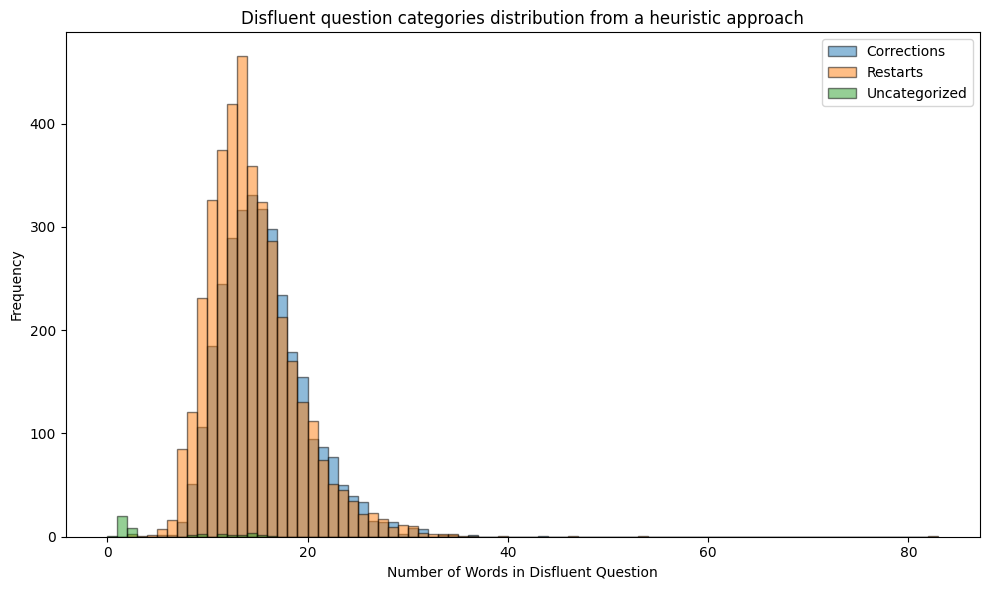

In [83]:
corrections_l = [len(e["input_text"].split()) for e in corrections]
restarts_l = [len(e["input_text"].split()) for e in restarts]
uncategorized_l = [len(e["input_text"].split()) for e in uncategorized]

# plt.hist(corrections_l, bins=30, alpha=0.6, label="Disfluent Corrections category")
# plt.hist(restarts_l, bins=30, alpha=0.6, label="Disfluent Restarts category")
# plt.hist(uncategorized_l, bins=30, alpha=0.6, label="Disfluent Uncategorized category")
# plt.xlabel("Categories")
# plt.ylabel("Frequency")
# plt.legend()
# plt.title("Disfluent categories from a heuristic approach")
# plt.show()
plt.figure(figsize=(10, 6))

bins = range(0, max(max(corrections_l), max(restarts_l), max(uncategorized_l)) + 2)

plt.hist(corrections_l, bins=bins, alpha=0.5, label="Corrections", edgecolor='black')
plt.hist(restarts_l, bins=bins, alpha=0.5, label="Restarts", edgecolor='black')
plt.hist(uncategorized_l, bins=bins, alpha=0.5, label="Uncategorized", edgecolor='black')

plt.xlabel("Number of Words in Disfluent Question")
plt.ylabel("Frequency")
plt.title("Disfluent question categories distribution from a heuristic approach")
plt.legend()
plt.tight_layout()
plt.show()

##### 5. Check for duplicates to see if a question gets overepresented relative to others and/or quality issues

In [55]:
# Create set of unique lowercased disfluent questions
disfluent_unique = set([e["input_text"].lower() for e in train_data])
print(f"Unique disfluent questions: {len(disfluent_unique)} / {len(train_data)}")

# Track seen questions and collect duplicates
seen = set()
disfluent_duplicates = []

for e in train_data:
    input_lower = e["input_text"].lower()
    if input_lower in seen:
        disfluent_duplicates.append(e)
    else:
        seen.add(input_lower)

print(f"Duplicated disfluent questions: {len(disfluent_duplicates)} / {len(train_data)}")

Unique disfluent questions: 7158 / 7182
Duplicated disfluent questions: 24 / 7182


In [56]:
disfluent_duplicates

[{'input_text': '#VALUE!',
  'target_text': 'How are Air force messages delivered '},
 {'input_text': 'Question n/a',
  'target_text': 'What interpretation of Islam is, for many of the adherents, the "gold standard" of their religion?'},
 {'input_text': '#VALUE!', 'target_text': 'What did this concept contradict '},
 {'input_text': 'question n/a',
  'target_text': 'Who suggested that imperialism was the "lowest" form of capitalism?'},
 {'input_text': 'question n/a',
  'target_text': 'What equation currently decribes the physics of force.'},
 {'input_text': '#VALUE!',
  'target_text': 'Telnet Used what  Interface technology'},
 {'input_text': '#VALUE!',
  'target_text': 'What 3 things does the Air Force work key on '},
 {'input_text': '#VALUE!',
  'target_text': 'What did the Apple system assign automatically '},
 {'input_text': '#VALUE!',
  'target_text': 'What are colonial powers blamed for?'},
 {'input_text': '#VALUE!',
  'target_text': 'Are California Bungalows located in the north 

##### 5.1 Need to look for values in input_text that are not valid (i.e. like #VALUE! or 'question n/a') and count them.

In [ ]:
# Count duplicates in input_text
input_text_counts = {}
for item in disfluent_duplicates:
    text = item["input_text"].lower()  # make it case-insensitive
    if text in input_text_counts:
        input_text_counts[text] += 1
    else:
        input_text_counts[text] = 1
        
# Print duplicates only
duplicates = {text: count for text, count in input_text_counts.items() if count > 1}

print("Duplicate input_text values and their counts:")
for text, count in duplicates.items():
    print(f"'{text}': {count} times")

{'#value!': 17, 'question n/a': 7}
Duplicate input_text values and their counts:
'#value!': 17 times
'question n/a': 7 times
